In [1]:
#quickstart
from pathlib import Path
import pandas as pd
from bids import BIDSLayout
from joblib import Parallel, delayed

import nilearn
import nibabel as nib
import nltools.prefs as prf
from nilearn import datasets, image, plotting, input_data
from nilearn.masking import apply_mask
from nilearn.image import resample_to_img
from nilearn.image import concat_imgs, index_img
import numpy as np
import matplotlib.pylab as plt

import rpy2
from rpy2.robjects.packages import importr
from pymer4 import Lmer
psych = importr('psych')


import rpy2.robjects as ro
from rpy2.robjects import pandas2ri

from rpy2.robjects.conversion import localconverter

import os
import glob
import seaborn as sns
from nltools.data import Brain_Data, Design_Matrix, Adjacency
from nltools.mask import expand_mask, roi_to_brain
from nltools.stats import zscore
from scipy.stats import binom, ttest_1samp
from sklearn.metrics import pairwise_distances
from nltools.stats import fdr, one_sample_permutation
from copy import deepcopy
from nltools.utils import get_anatomical
import nltools.plotting as nlplt
from datetime import date
from joblib import Parallel, delayed

from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA

from nilearn.input_data import NiftiMapsMasker,NiftiLabelsMasker
from nilearn.connectome import ConnectivityMeasure

import sys
import pandas as pd
import rpy2
from rpy2.robjects.packages import importr
from pymer4 import Lmer
psych = importr('psych')
import numpy as np

import rpy2.robjects as ro
from rpy2.robjects import pandas2ri

from rpy2.robjects.conversion import localconverter

import os
import glob
import seaborn as sns
from statistics import mean
import matplotlib.style as style

#dat_paths = pd.read_csv('/data/MBDU/midla/notebooks/campcc/dat_paths_11272019.csv') 
#atlas = image.load_img('/data/MBDU/midla/notebooks/campcc/hox_msdl_atlas.nii.gz')
#sub1 = image.load_img('/data/MBDU/midla/data/derivatives/fmriprep/rn_aroma_20190910_2mm/sub-20900/out/fmrip

%matplotlib inline
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', 500)
pd.set_option('display.width', 1000)

from IPython.core.display import display, HTML
display(HTML("<style>"
    + "#notebook { padding-top:0px !important; } " 
    + ".container { width:100% !important; } "
    + ".end_space { min-height:0px !important; } "
    + "</style>"))

In [9]:
#dat_paths = pd.read_csv('/data/MBDU/midla/data/derivatives/midla/primary_20200325/for_chris_svpair.csv')
dat_paths = pd.read_csv('/data/MBDU/midla/data/derivatives/midla/primary_20200325/for_chris.csv')
regions_extracted_img = image.load_img('/data/MBDU/midla/notebooks/campcc/test_retest/mid_basc_atlas_071820.nii.gz')

In [15]:
cfd_dict = {1:'none'}

cmd_list = []
atlas = '/data/MBDU/midla/notebooks/campcc/test_retest/mid_basc_atlas_071820.nii.gz'
dat_dir = '/data/MBDU/midla/data/derivatives/midla/primary_20200325/for_chris.csv'
i = 'ifc'
for cfd in cfd_dict.values():
    for _,row in dat_paths[0:1].iterrows():
        cmd_list.append(f'! export PATH=/data/MBDU/midla/env/bin:$PATH; python ts_extract.py {dat_dir} {atlas} {_} {i} {cfd}')

In [16]:
#cmds = '\n'.join(cmd_list[0:1]) + '\n'+'\n'.join(cmd_list[600:601])
cmds = '\n'.join(cmd_list)
from pathlib import Path
swarm_file = Path('/data/MBDU/midla/notebooks/campcc/swarms/ts_extract_12102020_no_cfds_test.txt')
swarm_file.write_text(cmds)

run_name = 'ts_extract_12102020_no_cfds_test'
swarm_log_dir = '/data/MBDU/midla/notebooks/campcc/swarms/logs'

In [17]:
! swarm -f $swarm_file -g 25 -t 2 -b 15 --time 0:16:00 --logdir $swarm_log_dir --partition=quick --job-name $run_name

4214163


In [41]:
#NOTE: the manual confound regression is BROKEN - use nilearn

# Running TS with new Confounds

In [74]:
dat_paths = pd.read_csv('/data/MBDU/midla/notebooks/campcc/test_retest/dat_paths_new_cfds_12102020.csv', index_col = 0)

In [102]:
#dat_paths = dat_paths.reset_index().drop(columns=['index'])

In [103]:
#dat_paths.to_csv('/data/MBDU/midla/notebooks/campcc/test_retest/dat_paths_new_cfds_12102020.csv')

In [60]:
#dat_paths = (dat_paths.drop_duplicates(subset=['subject', 'session', 'task', 'run']))

In [105]:
dat_paths

,subject,session,task,run,sv_pair,total_n_session,scanner,acq_date,confounds_path,image_path,mask_path,dm_path
0,20900,1,mid,1,3TC__DV26.0_R01_1725.a__3TC__DV26.0_R03_1831.b,2,3TC,2018-07-28,/data/MBDU/midla/data/derivatives/fmriprep/fmriprepv20.1.0_20200528_2mm_clifix_noaroma/sub-20900/out/fmriprep/sub-20900/ses-01/func/sub-20900_ses-01_task-mid_run-1_desc-confounds_regressors.tsv,/data/MBDU/midla/data/derivatives/fmriprep/fmriprepv20.1.0_20200528_2mm_clifix_noaroma/sub-20900/out/fmriprep/sub-20900/ses-01/func/sub-20900_ses-01_task-mid_run-1_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii.gz,/data/MBDU/midla/data/derivatives/fmriprep/fmriprepv20.1.0_20200528_2mm_clifix_noaroma/sub-20900/out/fmriprep/sub-20900/ses-01/func/sub-20900_ses-01_task-mid_run-1_space-MNI152NLin2009cAsym_res-2_desc-brain_mask.nii.gz,/data/MBDU/midla/data/derivatives/fitlins/fmriprepv20.1.0_20200528_2mm_clifix_noaroma_bp-True_isi-True_target-True_cosine-censor-trans-rot-phys_test/sub-20900/ses-01/run-1/wrk/wrk/fitlins_wf/design_matrix/mapflow/_design_matrix0/design.tsv
1,20900,4,mid,1,3TC__DV26.0_R01_1725.a__3TC__DV26.0_R03_1831.b,2,3TC,2019-08-06,/data/MBDU/midla/data/derivatives/fmriprep/fmriprepv20.1.0_20200528_2mm_clifix_noaroma/sub-20900/out/fmriprep/sub-20900/ses-04/func/sub-20900_ses-04_task-mid_run-1_desc-confounds_regressors.tsv,/data/MBDU/midla/data/derivatives/fmriprep/fmriprepv20.1.0_20200528_2mm_clifix_noaroma/sub-20900/out/fmriprep/sub-20900/ses-04/func/sub-20900_ses-04_task-mid_run-1_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii.gz,/data/MBDU/midla/data/derivatives/fmriprep/fmriprepv20.1.0_20200528_2mm_clifix_noaroma/sub-20900/out/fmriprep/sub-20900/ses-04/func/sub-20900_ses-04_task-mid_run-1_space-MNI152NLin2009cAsym_res-2_desc-brain_mask.nii.gz,/data/MBDU/midla/data/derivatives/fitlins/fmriprepv20.1.0_20200528_2mm_clifix_noaroma_bp-True_isi-True_target-True_cosine-censor-trans-rot-phys_test/sub-20900/ses-04/run-1/wrk/wrk/fitlins_wf/design_matrix/mapflow/_design_matrix0/design.tsv
2,21111,1,mid,1,3TA__DV25.1_R01_1617.b__3TA__DV26.0_R03_1831.b,2,3TA,2017-10-28,/data/MBDU/midla/data/derivatives/fmriprep/fmriprepv20.1.0_20200528_2mm_clifix_noaroma/sub-21111/out/fmriprep/sub-21111/ses-01/func/sub-21111_ses-01_task-mid_run-1_desc-confounds_regressors.tsv,/data/MBDU/midla/data/derivatives/fmriprep/fmriprepv20.1.0_20200528_2mm_clifix_noaroma/sub-21111/out/fmriprep/sub-21111/ses-01/func/sub-21111_ses-01_task-mid_run-1_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii.gz,/data/MBDU/midla/data/derivatives/fmriprep/fmriprepv20.1.0_20200528_2mm_clifix_noaroma/sub-21111/out/fmriprep/sub-21111/ses-01/func/sub-21111_ses-01_task-mid_run-1_space-MNI152NLin2009cAsym_res-2_desc-brain_mask.nii.gz,/data/MBDU/midla/data/derivatives/fitlins/fmriprepv20.1.0_20200528_2mm_clifix_noaroma_bp-True_isi-True_target-True_cosine-censor-trans-rot-phys_test/sub-21111/ses-01/run-1/wrk/wrk/fitlins_wf/design_matrix/mapflow/_design_matrix0/design.tsv
3,21111,5,mid,1,3TA__DV25.1_R01_1617.b__3TA__DV26.0_R03_1831.b,2,3TA,2019-03-30,/data/MBDU/midla/data/derivatives/fmriprep/fmriprepv20.1.0_20200528_2mm_clifix_noaroma/sub-21111/out/fmriprep/sub-21111/ses-05/func/sub-21111_ses-05_task-mid_run-1_desc-confounds_regressors.tsv,/data/MBDU/midla/data/derivatives/fmriprep/fmriprepv20.1.0_20200528_2mm_clifix_noaroma/sub-21111/out/fmriprep/sub-21111/ses-05/func/sub-21111_ses-05_task-mid_run-1_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii.gz,/data/MBDU/midla/data/derivatives/fmriprep/fmriprepv20.1.0_20200528_2mm_clifix_noaroma/sub-21111/out/fmriprep/sub-21111/ses-05/func/sub-21111_ses-05_task-mid_run-1_space-MNI152NLin2009cAsym_res-2_desc-brain_mask.nii.gz,/data/MBDU/midla/data/derivatives/fitlins/fmriprepv20.1.0_20200528_2mm_clifix_noaroma_bp-True_isi-True_target-True_cosine-censor-trans-rot-phys_test/sub-21111/ses-05/run-1/wrk/wrk/fitlins_wf/design_matrix/mapflow/_design_matrix0/design.tsv
4,21748,1,mid,2,3TC__DV26.0_R01_1725.a__3TC__DV26.0_R03_1831.b,4,3TC,2018

In [79]:
#new confounds just replaced old confounds
pd.read_csv('/data/MBDU/midla/data/derivatives/fmriprep/fmriprepv20.1.0_20200528_2mm_clifix_noaroma/sub-22228/out/fmriprep/sub-22228/ses-01/func/sub-22228_ses-01_task-mid_run-1_desc-confounds_regressors.tsv',sep='\t').iloc[0]

csf                                 3.271620e+03
csf_derivative1                     0.000000e+00
csf_power2                          1.070350e+07
csf_derivative1_power2              0.000000e+00
white_matter                        1.994756e+03
white_matter_derivative1            0.000000e+00
white_matter_derivative1_power2     0.000000e+00
white_matter_power2                 3.979053e+06
global_signal                       2.388521e+03
global_signal_derivative1           0.000000e+00
global_signal_derivative1_power2    0.000000e+00
global_signal_power2                5.705033e+06
std_dvars                           0.000000e+00
dvars                               0.000000e+00
framewise_displacement              0.000000e+00
rmsd                                0.000000e+00
t_comp_cor_00                       0.000000e+00
t_comp_cor_01                       0.000000e+00
t_comp_cor_02                       0.000000e+00
t_comp_cor_03                       0.000000e+00
a_comp_cor_00       

In [107]:
row

subject                                                                                                                                                                                                                                                      24169
session                                                                                                                                                                                                                                                          2
task                                                                                                                                                                                                                                                           mid
run                                                                                                                                                                                                                            

In [116]:
cfd_dict = {1:'phys',
           2:'strict',
            3:'stan'}

cmd_list = []
cmd_list2 = []
atlas = '/data/MBDU/midla/notebooks/campcc/test_retest/mid_basc_atlas_071820.nii.gz'
dat_dir = '/data/MBDU/midla/notebooks/campcc/test_retest/dat_paths_new_cfds_12102020.csv'
i = 'ifc'
for cfd in cfd_dict.values():
    for _,row in dat_paths.iterrows():
        if not os.path.isfile('/data/MBDU/midla/notebooks/campcc/test_retest/12102020/subject_ts/basc_ts_subject_{}_session_{}_run_{}_metric_{}_cfds_{}.csv'.format(row.subject,row.session,row.run,i,cfd)):
            cmd_list2.append(f'! export PATH=/data/MBDU/midla/env/bin:$PATH; python ts_extract.py {dat_dir} {atlas} {_} {i} {cfd}')

In [170]:
cmd_list_41 = []
cmd_list_41.append('! export PATH=/data/MBDU/midla/env/bin:$PATH; python ts_extract.py /data/MBDU/midla/notebooks/campcc/test_retest/dat_paths_new_cfds_12102020.csv /data/MBDU/midla/notebooks/campcc/test_retest/mid_basc_atlas_071820.nii.gz 41 ifc phys')

In [171]:
cmd_list_41

['! export PATH=/data/MBDU/midla/env/bin:$PATH; python ts_extract.py /data/MBDU/midla/notebooks/campcc/test_retest/dat_paths_new_cfds_12102020.csv /data/MBDU/midla/notebooks/campcc/test_retest/mid_basc_atlas_071820.nii.gz 41 ifc phys']

In [172]:
#cmds = '\n'.join(cmd_list[0:1]) + '\n'+'\n'.join(cmd_list[600:601])
cmds = '\n'.join(cmd_list_41)
from pathlib import Path
swarm_file = Path('/data/MBDU/midla/notebooks/campcc/swarms/ts_extract_12102020_new_cfds_41.txt')
swarm_file.write_text(cmds)

run_name = 'ts_extract_12102020_new_cfds_41'
swarm_log_dir = '/data/MBDU/midla/notebooks/campcc/swarms/logs'

In [173]:
! swarm -f $swarm_file -g 25 -t 2 -b 15 --time 0:16:00 --logdir $swarm_log_dir --partition=quick --job-name $run_name

4312422


In [168]:
! export PATH=/data/MBDU/midla/env/bin:$PATH; python ts_extract.py /data/MBDU/midla/notebooks/campcc/test_retest/dat_paths_new_cfds_12102020.csv /data/MBDU/midla/notebooks/campcc/test_retest/mid_basc_atlas_071820.nii.gz 41 ifc phys

ifc_phys_41
Extracting task timeseries from row 41
enter function
load image
/bin/bash: line 1: 31176 Bus error               python ts_extract.py /data/MBDU/midla/notebooks/campcc/test_retest/dat_paths_new_cfds_12102020.csv /data/MBDU/midla/notebooks/campcc/test_retest/mid_basc_atlas_071820.nii.gz 41 ifc phys


In [130]:
cmd_list = []
corr_dir = '/data/MBDU/midla/notebooks/campcc/test_retest/12102020/correlation_matrices'
dat_dir = '/data/MBDU/midla/notebooks/campcc/test_retest/dat_paths_new_cfds_12102020.csv'
output_dir = '/data/MBDU/midla/notebooks/campcc/test_retest/12102020/icc'
ts_dir = '/data/MBDU/midla/notebooks/campcc/test_retest/12102020/subject_ts'
for i in ['ifc']:
    for j in cfd_dict:
        cfd = cfd_dict[j]
        cmd_list.append(f'! export PATH=/data/MBDU/midla/env/bin:$PATH; python /data/MBDU/midla/notebooks/campcc/run_bootstrap.py {0} {corr_dir} {cfd} {dat_dir} {ts_dir} {i} {output_dir}')

In [131]:
cmds = '\n'.join(cmd_list)

from pathlib import Path
swarm_file = Path('/data/MBDU/midla/notebooks/campcc/swarms/icc_swarm_12102020.txt')
swarm_file.write_text(cmds)

run_name = 'icc_12102020'
swarm_log_dir = '/data/MBDU/midla/notebooks/campcc/swarms/logs'

In [132]:
! swarm -f $swarm_file -g 5 -t 2 -b 48 --time 0:05:00 --logdir $swarm_log_dir --partition=quick --job-name $run_name

4306073


In [122]:
bootlist = pd.read_csv('/data/MBDU/midla/notebooks/campcc/test_retest/12102020/bootstrap.csv')

In [125]:
subs = dat_paths.subject.unique()

pd.DataFrame(data=subs,columns=['boot_00000']).to_csv('/data/MBDU/midla/notebooks/campcc/test_retest/12102020/bootstrap.csv')

123

In [167]:
dat_paths.loc[dat_paths.subject == 23108]

,Unnamed: 0,subject,session,task,run,sv_pair,total_n_session,scanner,acq_date,confounds_path,image_path,mask_path,dm_path
41,41,23108,1,mid,1,3TA__DV25.1_R01_1617.b__3TA__DV25.1_R01_1617.b,3,3TA,2017-09-26,/data/MBDU/midla/data/derivatives/fmriprep/fmriprepv20.1.0_20200528_2mm_clifix_noaroma/sub-23108/out/fmriprep/sub-23108/ses-01/func/sub-23108_ses-01_task-mid_run-1_desc-confounds_regressors.tsv,/data/MBDU/midla/data/derivatives/fmriprep/fmriprepv20.1.0_20200528_2mm_clifix_noaroma/sub-23108/out/fmriprep/sub-23108/ses-01/func/sub-23108_ses-01_task-mid_run-1_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii.gz,/data/MBDU/midla/data/derivatives/fmriprep/fmriprepv20.1.0_20200528_2mm_clifix_noaroma/sub-23108/out/fmriprep/sub-23108/ses-01/func/sub-23108_ses-01_task-mid_run-1_space-MNI152NLin2009cAsym_res-2_desc-brain_mask.nii.gz,/data/MBDU/midla/data/derivatives/fitlins/fmriprepv20.1.0_20200528_2mm_clifix_noaroma_bp-True_isi-True_target-True_cosine-censor-trans-rot-phys_test/sub-23108/ses-01/run-1/wrk/wrk/fitlins_wf/design_matrix/mapflow/_design_matrix0/design.tsv
42,42,23108,2,mid,1,3TA__DV25.1_R01_1617.b__3TA__DV25.1_R01_1617.b,3,3TA,2018-02-13,/data/MBDU/midla/data/derivatives/fmriprep/fmriprepv20.1.0_20200528_2mm_clifix_noaroma/sub-23108/out/fmriprep/sub-23108/ses-02/func/sub-23108_ses-02_task-mid_run-1_desc-confounds_regressors.tsv,/data/MBDU/midla/data/derivatives/fmriprep/fmriprepv20.1.0_20200528_2mm_clifix_noaroma/sub-23108/out/fmriprep/sub-23108/ses-02/func/sub-23108_ses-02_task-mid_run-1_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii.gz,/data/MBDU/midla/data/derivatives/fmriprep/fmriprepv20.1.0_20200528_2mm_clifix_noaroma/sub-23108/out/fmriprep/sub-23108/ses-02/func/sub-23108_ses-02_task-mid_run-1_space-MNI152NLin2009cAsym_res-2_desc-brain_mask.nii.gz,/data/MBDU/midla/data/derivatives/fitlins/fmriprepv20.1.0_20200528_2mm_clifix_noaroma_bp-True_isi-True_target-True_cosine-censor-trans-rot-phys_test/sub-23108/ses-02/run-1/wrk/wrk/fitlins_wf/design_matrix/mapflow/_design_matrix0/design.tsv
43,43,23108,4,mid,1,3TA__DV25.1_R01_1617.b__3TA__DV26.0_R01_1725.a,3,3TA,2018-11-27,/data/MBDU/midla/data/derivatives/fmriprep/fmriprepv20.1.0_20200528_2mm_clifix_noaroma/sub-23108/out/fmriprep/sub-23108/ses-04/func/sub-23108_ses-04_task-mid_run-1_desc-confounds_regressors.tsv,/data/MBDU/midla/data/derivatives/fmriprep/fmriprepv20.1.0_20200528_2mm_clifix_noaroma/sub-23108/out/fmriprep/sub-23108/ses-04/func/sub-23108_ses-04_task-mid_run-1_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii.gz,/data/MBDU/midla/data/derivatives/fmriprep/fmriprepv20.1.0_20200528_2mm_clifix_noaroma/sub-23108/out/fmriprep/sub-23108/ses-04/func/sub-23108_ses-04_task-mid_run-1_space-MNI152NLin2009cAsym_res-2_desc-brain_mask.nii.gz,/data/MBDU/midla/data/derivatives/fitlins/fmriprepv20.1.0_20200528_2mm_clifix_noaroma_bp-True_isi-True_target-True_cosine-censor-trans-rot-phys_test/sub-23108/ses-04/run-1/wrk/wrk/fitlins_wf/design_matrix/mapflow/_design_matrix0/design.tsv


In [158]:
! export PATH=/data/MBDU/midla/env/bin:$PATH; python run_bootstrap.py 0 /data/MBDU/midla/notebooks/campcc/test_retest/12102020/correlation_matrices strict /data/MBDU/midla/notebooks/campcc/test_retest/dat_paths_new_cfds_12102020.csv /data/MBDU/midla/notebooks/campcc/test_retest/12102020/subject_ts ifc /data/MBDU/midla/notebooks/campcc/test_retest/12102020/icc

testing
passed, running
not rs file
run_bootstrap.py:185: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if (corr_matrices != []):
R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[wr

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSi

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSi

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSi

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSi

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSi

In [178]:
dat_paths.drop(labels=41).reset_index().to_csv('/data/MBDU/midla/notebooks/campcc/test_retest/dat_paths_new_cfds_12102020_drop41.csv')

In [179]:
! export PATH=/data/MBDU/midla/env/bin:$PATH; python run_bootstrap.py 0 /data/MBDU/midla/notebooks/campcc/test_retest/12102020/correlation_matrices phys /data/MBDU/midla/notebooks/campcc/test_retest/dat_paths_new_cfds_12102020_drop41.csv /data/MBDU/midla/notebooks/campcc/test_retest/12102020/subject_ts ifc /data/MBDU/midla/notebooks/campcc/test_retest/12102020/icc

testing
passed, running
not rs file
run_bootstrap.py:185: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if (corr_matrices != []):
R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[wr

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSi

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSi

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSi

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSi

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



In [160]:
! export PATH=/data/MBDU/midla/env/bin:$PATH; python run_bootstrap.py 0 /data/MBDU/midla/notebooks/campcc/test_retest/12102020/correlation_matrices stan /data/MBDU/midla/notebooks/campcc/test_retest/dat_paths_new_cfds_12102020.csv /data/MBDU/midla/notebooks/campcc/test_retest/12102020/subject_ts ifc /data/MBDU/midla/notebooks/campcc/test_retest/12102020/icc

testing
passed, running
not rs file
run_bootstrap.py:185: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if (corr_matrices != []):
R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[wr

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSi

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSi

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSi

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSi

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSi

In [183]:
phys = pd.read_csv('/data/MBDU/midla/notebooks/campcc/test_retest/12102020/icc/ifc_icc_boot_00000_cfd_phys.csv')
phys['cfds'] = 'phys'
stan = pd.read_csv('/data/MBDU/midla/notebooks/campcc/test_retest/12102020/icc/ifc_icc_boot_00000_cfd_stan.csv')
stan['cfds'] = 'stan'
strict = pd.read_csv('/data/MBDU/midla/notebooks/campcc/test_retest/12102020/icc/ifc_icc_boot_00000_cfd_strict.csv')
strict['cfds'] = 'strict'

In [185]:
measure_df = phys.append(stan).append(strict)

In [186]:
measure_df.loc[measure_df.type == 'ICC2'].groupby('cfds')[['ICC']].agg(['mean','std','count'])

ICC                
            mean       std count
cfds                            
phys    0.413784  0.069098  2016
stan    0.425441  0.068661  2016
strict  0.404806  0.068227  2016

In [143]:
def run_corr(metric,cfd,dat_paths,ts_dir,corr_output_dir,icc_output_dir,bs_col):
    if not os.path.isfile(f'{icc_output_dir}/rs_icc_{bs_col.name}_cfd_{cfd_alph}.csv'):
        print('not rs file')
        rs_ts = []
#         if metric == ['ifc']:
#             for _,row in dat_paths.iterrows():
#                 rs_ts.append(lr_ifc(row.cfds_physio_path_x,row.task_ts_path, cfd))
#         elif metric == ['bgc']:
#             for _,row in dat_paths.iterrows():
#                 rs_ts.append(lr_bg(row.cfds_physio_path_x,row.task_ts_path, cfd))
#         elif metric == ['rs']:
#             for _,row in dat_paths.iterrows():
#                 rs_ts.append(lr_rest(row.cfds_physio_path_y,row.rest_ts_path, cfd))
#         else:
#             for _,row in dat_paths.iterrows():
#                 rs_ts.append(lr_concat(row, cfd))
        for _,row in dat_paths.iterrows():
            fname = f'{ts_dir}/basc_ts_subject_{row.subject}_session_{int(row.session)}_run_{int(row.run)}_metric_{metric}_cfds_{cfd}.csv'
            rs_ts.append(pd.read_csv(fname).values)

In [149]:
dat_paths = '/data/MBDU/midla/notebooks/campcc/test_retest/dat_paths_new_cfds_12102020.csv'
dat_paths = pd.read_csv(dat_paths)
dat_paths = pd.DataFrame(bs_col).rename(columns={bs_col.name:'subject'}).merge(dat_paths, how='left', on=['subject'])
for _,row in dat_paths.iterrows():
        fname = f'{ts_dir}/basc_ts_subject_{row.subject}_session_{int(row.session)}_run_{int(row.run)}_metric_{metric}_cfds_{cfd}.csv'
        rs_ts.append(pd.read_csv(fname).values)

ValueError: cannot convert float NaN to integer

In [154]:
dat_paths = pd.read_csv('/data/MBDU/midla/notebooks/campcc/test_retest/dat_paths_new_cfds_12102020.csv')
len(dat_paths.subject.unique())

123

In [155]:
len(bs_col)

32

In [145]:
bs_num = 0
corr_output_dir = '/data/MBDU/midla/notebooks/campcc/test_retest/12102020/correlation_matrices'
cfd_alph = 'strict'
dat_paths = '/data/MBDU/midla/notebooks/campcc/test_retest/dat_paths_new_cfds_12102020.csv'
ts_dir = '/data/MBDU/midla/notebooks/campcc/test_retest/12102020/subject_ts'
metric = 'ifc'
icc_output_dir = '/data/MBDU/midla/notebooks/campcc/test_retest/12102020/icc'

boots = pd.read_csv('/data/MBDU/midla/notebooks/campcc/test_retest/bootstrap.csv')
bs_col = boots.loc[:, f'boot_{int(bs_num):05d}']
print('testing')
if not os.path.isfile(f'{corr_output_dir}/{metric}_cm_{bs_col.name}_cfd_{cfd_alph}.csv'):
    print('passed, running')
    dat_paths = pd.read_csv(dat_paths)
    dat_paths = pd.DataFrame(bs_col).rename(columns={bs_col.name:'subject'}).merge(dat_paths, how='left', on=['subject'])

run_corr(metric,cfd_alph,dat_paths,ts_dir,corr_output_dir,icc_output_dir,bs_col)

testing
passed, running
not rs file


ValueError: cannot convert float NaN to integer

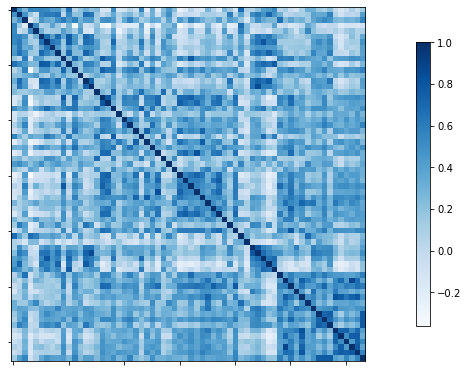

In [89]:
correlation_measure = ConnectivityMeasure(kind='correlation')
correlation_matrices = correlation_measure.fit_transform([pd.read_csv('/data/MBDU/midla/notebooks/campcc/test_retest/12102020/subject_ts/basc_ts_subject_22293_session_4_run_1_metric_ifc_cfds_strict.csv',header=None).values])
plotting.plot_matrix(correlation_matrices[0],cmap='Blues')

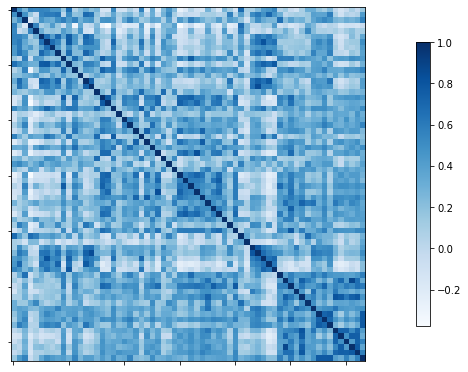

In [91]:
correlation_measure = ConnectivityMeasure(kind='correlation')
correlation_matrices = correlation_measure.fit_transform([pd.read_csv('/data/MBDU/midla/notebooks/campcc/test_retest/12102020/subject_ts/basc_ts_subject_22293_session_4_run_1_metric_ifc_cfds_stan.csv',header=None).values])
plotting.plot_matrix(correlation_matrices[0],cmap='Blues')

In [139]:
bs_col = pd.read_csv('/data/MBDU/midla/notebooks/campcc/test_retest/12102020/bootstrap.csv').loc[:, f'boot_{int(0):05d}']

corr_output_dir = '/data/MBDU/midla/notebooks/campcc/test_retest/12102020/correlation_matrices'
dat_paths = '/data/MBDU/midla/notebooks/campcc/test_retest/dat_paths_new_cfds_12102020.csv'
output_dir = '/data/MBDU/midla/notebooks/campcc/test_retest/12102020/icc'
ts_dir = '/data/MBDU/midla/notebooks/campcc/test_retest/12102020/subject_ts'
metric = 'ifc'
cfd_alph = 'stan'

if not os.path.isfile(f'{corr_output_dir}/{metric}_cm_{bs_col.name}_cfd_{cfd_alph}.csv'):
    print('passed, running')
    dat_paths = pd.read_csv(dat_paths)
    dat_paths = pd.DataFrame(bs_col).rename(columns={bs_col.name:'subject'}).merge(dat_paths, how='left', on=['subject'])

passed, running


In [141]:
for _,row in dat_paths.iterrows():
        fname = f'{ts_dir}/basc_ts_subject_{row.subject}_session_{int(row.session)}_run_{int(row.run)}_metric_{metric}_cfds_{cfd}.csv'